In [1]:
import sys
sys.path.append("/work/multi_doc_analyzer")
sys.path.append("/work/relation_extraction/Bert_model/data/")

import torch as T
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.cuda
from allennlp.nn import util as nn_util
from multi_doc_analyzer.structure.structure import *
from multi_doc_analyzer.tokenization.tokenizer import MDATokenizer
from tqdm import tqdm

from allennlp.data.dataset_readers import DatasetReader
from allennlp.data.tokenizers import Token, Tokenizer, WordTokenizer
from allennlp.data.token_indexers import TokenIndexer

from allennlp.data.instance import Instance
from allennlp.data.fields import TextField, LabelField, ArrayField

from ace05_set_reader import ACE05Reader

from allennlp.data.vocabulary import Vocabulary
from allennlp.data.iterators import BucketIterator, DataIterator, BasicIterator
from allennlp.nn.util import get_text_field_mask
from allennlp.models import Model
from allennlp.modules.text_field_embedders import TextFieldEmbedder
import random

from allennlp.data.token_indexers import PretrainedBertIndexer
from allennlp.modules.text_field_embedders import BasicTextFieldEmbedder
from allennlp.modules.token_embedders.bert_token_embedder import PretrainedBertEmbedder

from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import csv

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:21: DeprecationWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


In [2]:
train_path = "/work/LDC2006T06/dataset/train/"
test_path = "/work/LDC2006T06/dataset/test/"
model_folder = "/work/model_checkpoint/bert_model_checkpoint/"
output_path = "/work/relation_extraction/Bert_model/analysis/"

In [3]:
class Config(dict):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        for k, v in kwargs.items():
            setattr(self, k, v)
    
    def set(self, key, val):
        self[key] = val
        setattr(self, key, val)
        
config = Config(
    seed=1,
    batch_size=64,
    lr=3e-4,                # learning rate
    epochs=50,
    hidden_sz=128,
    arg_sz=20,
    max_seq_len=200
)

In [4]:
USE_GPU = T.cuda.is_available()
USE_GPU

True

In [5]:
# set seed for both CPU and CUDA
T.manual_seed(config.seed)

In [6]:
# from ace05_set_reader import ACE05Reader
# train_path = "/work/LDC2006T06/dataset/train/"
# reader = ACE05Reader(lang='en')
# doc_dicts = reader.read(train_path)
# tokenizer = MDATokenizer('bert-en')
# for doc in doc_dicts.values():
#     tokenizer.annotate_document(doc)
#     for s in doc.sentences: 
        

In [7]:
e_type2idx = {'X':0, 'O': 1, 'PER': 2, 'ORG': 3, 'LOC': 4, 'GPE': 5, 'FAC': 6, 'VEH': 7, 'WEA': 8}

r_label2idx = {'PHYS-lr': 1, 'PART-WHOLE-lr': 2, 'PER-SOC-lr': 3, 'ORG-AFF-lr': 4, 'ART-lr': 5, 'GEN-AFF-lr': 6,
               'PHYS-rl': 7, 'PART-WHOLE-rl': 8, 'PER-SOC-rl': 9, 'ORG-AFF-rl': 10, 'ART-rl': 11, 'GEN-AFF-rl': 12,
               'NONE': 0}

# r_label2idx = {'PHYS': 1, 'PART-WHOLE': 2, 'PER-SOC': 3, 'ORG-AFF': 4, 'ART': 5, 'GEN-AFF': 6, 'NONE': 0}

r_idx2label = {v: k for k, v in r_label2idx.items()}

class RelationDatasetReader(DatasetReader):
    """
    Reads Structure object formatted datasets files, and creates AllenNLP instances.
    """
    def __init__(self, tokenizer: Tokenizer=None, token_indexers: Dict[str, TokenIndexer]=None, 
                 MAX_WORDPIECES: int=config.max_seq_len, 
                 is_training = False, ace05_reader: ACE05Reader=None):
        # make sure results may be reproduced when sampling...
        super().__init__(lazy=False)
        random.seed(0)
        self.is_training = is_training
        self.ace05_reader = ace05_reader
        
        # NOTE AllenNLP automatically adds [CLS] and [SEP] word peices in the begining and end of the context,
        # therefore we need to subtract 2
        self.MAX_WORDPIECES = MAX_WORDPIECES - 2
        
        self.tokenizer = tokenizer or WordTokenizer()
        
        # BERT specific init
        self._token_indexers = token_indexers

    def text_to_instance(self, sentence: Sentence) -> Instance:
#         sentence_tokens = [Token(x) for x in self.tokenizer(sentence.text)]
#         sentence_tokens = [Token(i) for t in sentence.text for i in self.tokenizer(t)]
#         sentence_tokens = [Token(text=t) for t in sentence.text]
        
#         sentence_tokens = []
#         for t in sentence.tokens:
#             sentence_tokens.append(Token(text=t.text))

#         for t in sentence.text:
#             td = self.tokenizer(t)
#             assert len(td) == 1 or len(td) == 0
#             if td:
#                 sentence_tokens.append(Token(text=td[0]))
#             else:
#                 sentence_tokens.append(Token(text='[MASK]'))

#         sentence_field = TextField(sentence_tokens, self._token_indexers)
#         fields = {"tokens": sentence_field}

#         char_list_field = ListField([t for t in sentence.text])
#         fields['char_list'] = char_list_field

        e_tuple_check_dicts = {} # {(train_arg_l.id, train_arg_r.id):true_label, ...}
        if self.is_training: 
            for r in sentence.relation_mentions:
                train_arg_l, train_arg_r, true_label = r.get_left_right_args()
                e_tuple_check_dicts[(train_arg_l.id, train_arg_r.id)] = true_label

        # construct pair entities
        for arg_left_idx in range(len(sentence.entity_mentions)-1):
            for arg_right_idx in range(arg_left_idx+1, len(sentence.entity_mentions)):
                field = {}
                sentence_tokens = []

                for t in sentence.tokens:
                    sentence_tokens.append(Token(text=t.text))
                
                sentence_field = TextField(sentence_tokens, self._token_indexers)
                fields = {"tokens": sentence_field}
                    
                arg_left = sentence.entity_mentions[arg_left_idx]
                arg_right = sentence.entity_mentions[arg_right_idx]
                arg_vec = T.zeros(self.MAX_WORDPIECES + 2, dtype=T.long)
                arg_vec[:len(sentence_tokens)+2] = 1

                # +1 because the first token is [CLS]
                arg_vec[arg_left.token_b+1:arg_left.token_e+1] = e_type2idx[arg_left.type]
                arg_vec[arg_right.token_b+1:arg_right.token_e+1] = e_type2idx[arg_right.type]
                fields["arg_idx"] = ArrayField(arg_vec)


#                 fields["arg_left"] = SpanField(arg_left.char_b, arg_left.char_e, char_list_field)
#                 fields["arg_right"] = SpanField(arg_right.char_b, arg_right.char_e, char_list_field)
                if self.is_training:
                    if (arg_left.id, arg_right.id) in e_tuple_check_dicts.keys():
                        fields["label"] = LabelField(r_label2idx[e_tuple_check_dicts[(arg_left.id, arg_right.id)]], skip_indexing=True)
                    else:
                        fields["label"] = LabelField(r_label2idx['NONE'], skip_indexing=True)
                yield Instance(fields)
    
    def _read(self, file_path: str)->Iterator: 
        doc_dicts = self.ace05_reader.read(file_path)
        tokenizer = MDATokenizer('bert-en')
        for doc in doc_dicts.values():
            tokenizer.annotate_document(doc)
            for s in doc.sentences: 
                if len(s.tokens) <= config.max_seq_len:
                    for instance in self.text_to_instance(s):
                        yield instance

In [8]:
# ace05_reader = ACE05Reader(lang='en')

# token_indexer = PretrainedBertIndexer(
#     pretrained_model="bert-base-uncased",
# #         max_pieces=config.max_seq_len,
# #         do_lowercase=False               # for cased condition
# )

# # AllenNLP DatasetReader
# reader = RelationDatasetReader(
#     is_training=True, 
#     ace05_reader=ace05_reader, 
#     tokenizer=lambda s: token_indexer.wordpiece_tokenizer(s),
#     token_indexers={"tokens": token_indexer}
# )

# train_ds = reader.read(train_path)

0it [00:00, ?it/s]
 99%|█████████▉| 348/351 [00:02<00:00, 122.02it/s]
2029it [00:21,  3.55s/it][00:02<00:00, 122.54it/s]

ORG-AFF
FBI
FBI
error! relation argument positions error!
ORG-AFF
Department
Department
error! relation argument positions error!
ORG-AFF
CIA
CIA
error! relation argument positions error!


67082it [00:44, 1509.87it/s]


In [9]:
class BERT(Model):
    def __init__(self, word_embeddings: TextFieldEmbedder,
                out_sz: int=len(r_label2idx)):
        super().__init__(vocab)
        self.word_embeddings = word_embeddings
        self._entity_embeddings = T.nn.Embedding(num_embeddings=len(e_type2idx), embedding_dim=config.arg_sz, padding_idx=0)
        self.gru = T.nn.GRU(word_embeddings.get_output_dim()+config.arg_sz, config.hidden_sz, batch_first=True)
        self.projection = nn.Linear(config.hidden_sz, out_sz)
        self.loss = nn.CrossEntropyLoss()
        
    def forward(self, tokens: Dict[str, T.tensor], arg_idx: T.tensor, label: T.tensor = None) -> Dict[str, T.tensor]:
        mask = get_text_field_mask(tokens)
        
        embeddings = self.word_embeddings(tokens)
        pad_len = embeddings.shape[-2]
#         print(pad_len)
        
        arg_idx = arg_idx[:,:pad_len]
        arg_idx = arg_idx.type(T.long)
        
        arg_emb = self._entity_embeddings(arg_idx)

        concat = T.cat((embeddings, arg_emb), -1)
        ot, ht = self.gru(concat, None) # revise this "None"
        ot = ot[:,-1,:]    
        class_logits = self.projection(ot)
        
        output = {"class_logits": class_logits}
        output["loss"] = self.loss(class_logits, label)

        return output

In [10]:
from scipy.special import expit # the sigmoid function
def tonp(tsr): return tsr.detach().cpu().numpy()

In [11]:
# Predict
class Predictor:
    def __init__(self, model: Model, iterator: DataIterator,
                 cuda_device: int=-1) -> None:
        self.model = model
        self.iterator = iterator
        self.cuda_device = cuda_device
        
    def _extract_data(self, batch) -> np.ndarray:
        out_dict = self.model(**batch)
        return expit(tonp(out_dict["class_logits"]))
    
    def predict(self, ds: Iterable[Instance]) -> np.ndarray:
        pred_generator = self.iterator(ds, num_epochs=1, shuffle=False)
        self.model.eval()
        pred_generator_tqdm = tqdm(pred_generator, total=self.iterator.get_num_batches(ds))
        preds = []
        with T.no_grad():
            for batch in pred_generator_tqdm:
                batch = nn_util.move_to_device(batch, self.cuda_device)
                preds.append(self._extract_data(batch))
        return np.concatenate(preds, axis=0)

In [12]:
def plot_comfusion_matrix(label_classes, predict_classes, out_folder, file_name):
    label_types = list(r_idx2label.values())

    cm = confusion_matrix(label_classes, predict_classes, label_types)
    print(cm)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    for (i, j), z in np.ndenumerate(cm):
        ax.text(j, i, '{:0.0f}'.format(z), ha='center', va='center', color='white')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + label_types)
    ax.set_yticklabels([''] + label_types)
    plt.xlabel('Predicted')
    plt.ylabel('True')

    plt.savefig(out_folder + 'confusion_matrix_' + file_name + '.png')
    plt.show()

    f1 = f1_score(label_classes, predict_classes, average='macro')*100
    
    print("Accuracy:", sum(cm[i][i] for i in range(len(cm))) / len(label_classes))
    print("F1 score:", f1)

In [29]:
def err_analyze(ds, true, pred, opt):
    
    # classify different kinds of error
    detail = [[[] for j in range(len(r_label2idx))] for i in range(len(r_label2idx))]
    for i in range(len(ds)):
         if true[i] != pred[i]:
            detail[r_label2idx[true[i]]][r_label2idx[pred[i]]].append(i)
    
    # print into a csv file
    with open(output_path + "error_detail_" + opt + ".csv", "w", newline='') as f:
        writer = csv.writer(f)
        writer.writerow(["Sentence", "Two_Entity", "Predict", "Label", "idx"])
        for j in range(len(detail)):
            for k in range(len(detail)):
                with_element = 0
                if k == j:
                    continue
                for i in detail[j][k]:
                    with_element = 1
                    ent1 = []
                    ent2 = []
                    seq = 0
                    prev = 0
                    for g in range(len(vars(ds[i].fields['arg_idx'])['array'])):
                        if int(vars(ds[i].fields['arg_idx'])['array'][g]) != 1 and int(vars(ds[i].fields['arg_idx'])['array'][g]) != 0:
                            if ent1 == [] or (seq == 1 and prev == vars(ds[i].fields['arg_idx'])['array'][g]):
                                prev = vars(ds[i].fields['arg_idx'])['array'][g]
                                seq = 1
                                ent1.append(vars(ds[i].fields['tokens'])['tokens'][g-1])
                            else:
                                seq = 2
                                ent2.append(vars(ds[i].fields['tokens'])['tokens'][g-1])
                        else: 
                            seq = 0
    
                    tostr = lambda a: [str(a[i]) for i in range(len(a))] 
                    writer.writerow([" ".join(tostr(vars(ds[i].fields['tokens'])['tokens'])), [ent1, ent2], pred[i], true[i], i])
                if with_element == 1:
                    writer.writerow("")

In [16]:

if __name__ == '__main__':

    ace05_reader = ACE05Reader(lang='en')
    
    token_indexer = PretrainedBertIndexer(
        pretrained_model="bert-base-uncased",
#         max_pieces=config.max_seq_len,
#         do_lowercase=False               # for cased condition
    )
 
	# AllenNLP DatasetReader
    reader = RelationDatasetReader(
        is_training=True, 
        ace05_reader=ace05_reader, 
        tokenizer=lambda s: token_indexer.wordpiece_tokenizer(s),
        token_indexers={"tokens": token_indexer}
    )

    train_ds = reader.read(train_path)
    print(len(train_ds))
#     for e in range(20):
#         print(len(vars(train_ds[e].fields['tokens'])['tokens']))
#         print(vars(train_ds[e].fields['tokens']))
#         print(type(vars(train_ds[0].fields['arg_idx'])['array'][0]))
#         print(vars(train_ds[e].fields['arg_idx']))
#         print(vars(train_ds[e].fields['label']))
    
    vocab = Vocabulary()
    iterator = BucketIterator(batch_size=config.batch_size, sorting_keys=[("tokens", "num_tokens")])
    iterator.index_with(vocab)

    bert_embedder = PretrainedBertEmbedder(
        pretrained_model="bert-base-uncased",
        top_layer_only=True, # conserve memory   
    )
    word_embeddings: TextFieldEmbedder = BasicTextFieldEmbedder({"tokens": bert_embedder},
                                                                # we'll be ignoring masks so we'll need to set this to True
                                                               allow_unmatched_keys = True)
    model = BERT(word_embeddings)
    if USE_GPU:
        model.cuda()

    optimizer = optim.Adam(model.parameters(), lr=config.lr)

0it [00:00, ?it/s]
 96%|█████████▋| 338/351 [00:02<00:00, 130.07it/s]
3064it [00:19,  1.53s/it][00:02<00:00, 141.03it/s]

ORG-AFF
FBI
FBI
error! relation argument positions error!
ORG-AFF
Department
Department
error! relation argument positions error!
ORG-AFF
CIA
CIA
error! relation argument positions error!


67082it [00:42, 1572.56it/s]


67082
<class 'torch.Tensor'>


In [17]:
    # training
    from allennlp.training.trainer import Trainer

    trainer = Trainer(
        model=model,
        optimizer=optimizer,
        iterator=iterator,
        train_dataset=train_ds,
        cuda_device=0 if USE_GPU else -1,
        num_epochs=config.epochs,
    )

In [18]:
    # train the model 
#     metrics = trainer.train()

In [19]:
    # load model
    model.load_state_dict(T.load(model_folder + "/model.th"))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [20]:
    # save 
    with open(model_folder+'model.th', 'wb') as f:
        T.save(model.state_dict(), f)

In [25]:
    # training data analysis
    seq_iterator = BasicIterator(batch_size=config.batch_size)
    seq_iterator.index_with(vocab)
    
    predictor = Predictor(model, seq_iterator, cuda_device=0 if USE_GPU else -1)
    train_preds = predictor.predict(train_ds) 
    
    label_types = [r_idx2label.get(i.fields['label'].label) for i in train_ds]
    predict_types = [r_idx2label.get(i) for i in np.argmax(train_preds, axis=-1)]
    err_analyze(train_ds, label_types, predict_types, "train")

100%|██████████| 1049/1049 [01:52<00:00,  9.36it/s]


[[  613     0     0     0     0     0     1     0     0     0     0     0
     10]
 [    0   266     0     0     0     0     0     0     0     0     0     0
      2]
 [    0     0   214     0     0     0     0     0     0     0     0     0
     46]
 [    0     0     0   335     0     0     0     0     0     0     0     0
     17]
 [    0     0     0     0   256     0     0     0     0     0     0     0
      8]
 [    0     0     0     0     0   134     0     0     0     0     0     0
      1]
 [    0     0     0     0     0     0   102     0     0     0     0     0
      6]
 [    0     1     0     0     1     0     0   224     0     0     1     0
      3]
 [    0     0     7     0     0     0     0     0    10     0     0     0
      4]
 [    0     0     0     0     0     1     0     0     0   541     0     0
      4]
 [    0     0     0     0     0     0     0     0     0     0    42     0
      5]
 [    0     0     0     0     0     1     0     0     0     0     0   175
      1]
 [  

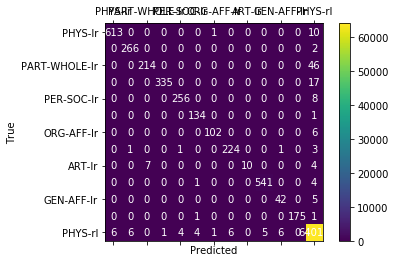

Accuracy: 0.9976297665543663
F1 score: 94.02677867688016


In [26]:
    plot_comfusion_matrix(label_types, predict_types, output_path, "train_full")

In [30]:
    # testing data analysis
    
    # AllenNLP DatasetReader
    reader = RelationDatasetReader(
        is_training=True, 
        ace05_reader=ace05_reader, 
        tokenizer=lambda s: token_indexer.wordpiece_tokenizer(s),
        token_indexers={"tokens": token_indexer}
    )
    
    test_ds = reader.read(test_path)
    print(len(test_ds))
    seq_iterator = BasicIterator(batch_size=config.batch_size)
    seq_iterator.index_with(vocab)
    
    predictor = Predictor(model, seq_iterator, cuda_device=0 if USE_GPU else -1)
    test_preds = predictor.predict(test_ds) 
    
    label_types = [r_idx2label.get(i.fields['label'].label) for i in test_ds]
    predict_types = [r_idx2label.get(i) for i in np.argmax(test_preds, axis=-1)]  
    
    err_analyze(test_ds, label_types, predict_types, "test")

0it [00:00, ?it/s]
 86%|████████▋ | 69/80 [00:00<00:00, 160.11it/s]
13691it [00:12, 1124.02it/s]0<00:00, 153.92it/s]
  0%|          | 0/214 [00:00<?, ?it/s]

13691


100%|██████████| 214/214 [00:25<00:00,  8.31it/s]


[[   50     1     0     0     0     1     0     0     0     0     0     0
     99]
 [    3    38     0     0     0     0     0     1     0     0     0     1
     19]
 [    0     0    16     0     0     0     0     0     0     1     0     0
     36]
 [    0     0     0    20     0     1     0     0     0     0     0     0
     40]
 [    1     0     0     0    26     0     0     0     0     0     0     0
     60]
 [    4     1     0     1     0    10     0     0     0     0     0     0
     12]
 [    0     0     0     0     0     0     4     0     0     0     0     0
     29]
 [    0     0     0     0     1     0     0    22     0     0     0     0
     31]
 [    0     0     1     0     0     0     0     0     0     0     0     0
      0]
 [    0     0     0     0     0     0     0     0     0    92     0     2
     78]
 [    0     2     0     0     0     0     0     0     0     0     1     0
     15]
 [    0     0     1     0     0     0     0     1     0     3     0    11
     17]
 [  

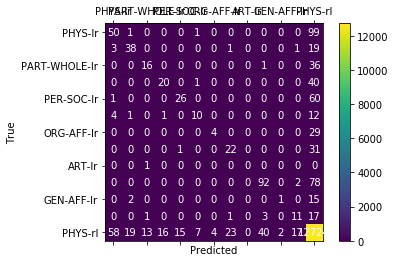

Accuracy: 0.950551457161639
F1 score: 40.403203350429045


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [28]:
    plot_comfusion_matrix(label_types, predict_types, output_path, "test_full")